# Decision Trees with Titanic Kaggle Dataset

In [1]:
import pandas
from dtreeviz.trees import dtreeviz
data = pandas.read_csv("/Users/likejazz/workspace/github.com/likejazz/jupyter-notebooks/machine-learning/data/titanic.csv")
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [2]:
y, X = data['survived'], data[['pclass','sex','age','sibsp', 'fare']].fillna(0)
X['sex'].replace(['female','male'],[0,1],inplace=True)
X['age'] = X['age'].astype(int)
y.head(), X.head()

(0    1
 1    1
 2    0
 3    0
 4    0
 Name: survived, dtype: int64,    pclass  sex  age  sibsp      fare
 0       1    0   29      0  211.3375
 1       1    1    0      1  151.5500
 2       1    0    2      1  151.5500
 3       1    1   30      1  151.5500
 4       1    0   25      1  151.5500)

In [3]:
X.columns

Index(['pclass', 'sex', 'age', 'sibsp', 'fare'], dtype='object')

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=123)
len(X_train), len(y_train), len(X_test), len(y_test)

(1047, 1047, 262, 262)

In [5]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(random_state=42, max_depth=3)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8091603053435115

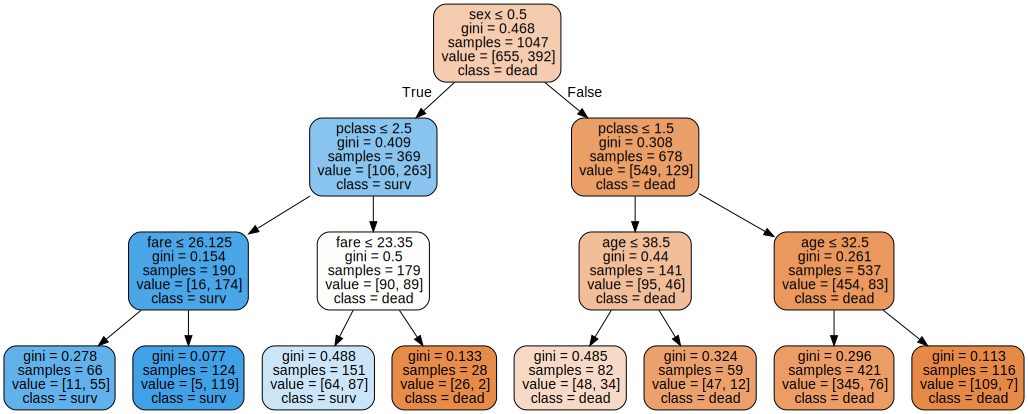

In [6]:
import os
from tempfile import mkstemp
import subprocess

from sklearn.tree.export import export_graphviz

def convert_decision_tree_to_ipython_image(clf, feature_names=None, class_names=None,
                                           image_filename=None, tmp_dir=None):
    dot_filename = mkstemp(suffix='.dot', dir=tmp_dir)[1]
    with open(dot_filename, "w") as out_file:
        export_graphviz(clf, out_file=out_file,
                        feature_names=feature_names,
                        class_names=class_names,
                        filled=True, rounded=True,
                        special_characters=True)

    import graphviz
    from IPython.display import display

    with open(dot_filename) as f:
        dot_graph = f.read()
    display(graphviz.Source(dot_graph))
    os.remove(dot_filename)

convert_decision_tree_to_ipython_image(clf, image_filename='titanic.png', feature_names=X.columns, class_names=["dead", "surv"])

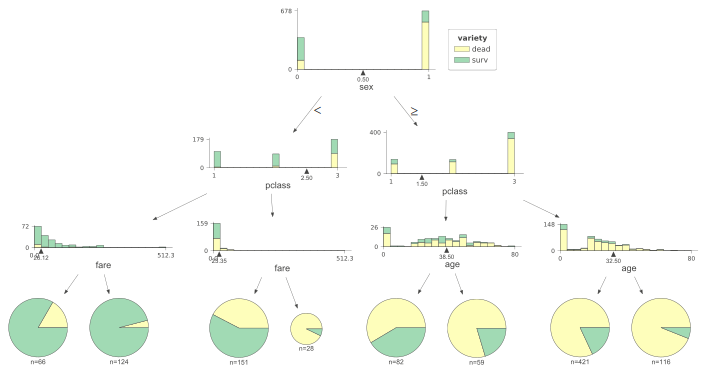

In [7]:
viz = dtreeviz(clf, X_train, y_train, target_name='variety', 
               feature_names=X.columns,
               class_names=["dead", "surv"],
)
viz

In [8]:
clf.feature_importances_

array([0.20633449, 0.69231053, 0.03019166, 0.        , 0.07116332])

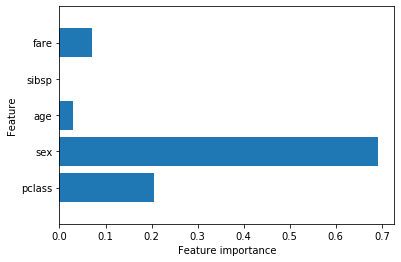

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
def plot_feature_importances(clf):
    n_features = X_train.shape[1]
    plt.barh(range(n_features), clf.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    
plot_feature_importances(clf)

In [10]:
from sklearn import ensemble
clf_rf = ensemble.RandomForestClassifier(n_estimators=50, random_state=800)
clf_rf.fit(X_train, y_train)
clf_rf.score(X_test, y_test)

0.8129770992366412

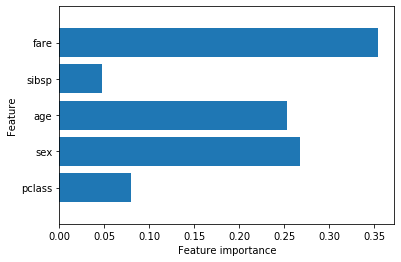

In [11]:
plot_feature_importances(clf_rf)

In [12]:
from sklearn import ensemble
clf_gd = ensemble.GradientBoostingClassifier(random_state=800)
clf_gd.fit(X_train, y_train)
clf_gd.score(X_test, y_test)

0.8282442748091603

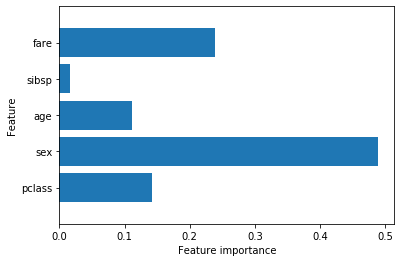

In [13]:
plot_feature_importances(clf_gd)

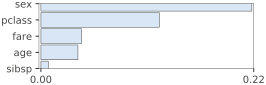

In [14]:
from rfpimp import importances, plot_importances

imp = importances(clf_rf, X_test, y_test) # permutation
viz = plot_importances(imp)
viz

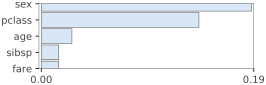

In [15]:
from rfpimp import importances, plot_importances

imp = importances(clf_gd, X_test, y_test)
viz = plot_importances(imp)
viz

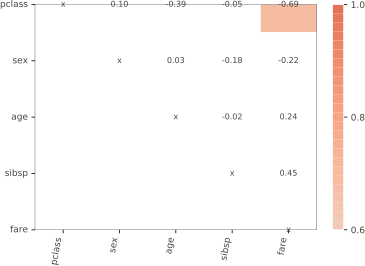

In [16]:
from rfpimp import plot_corr_heatmap
viz = plot_corr_heatmap(X_train)
viz

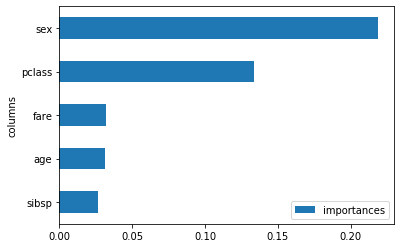

In [17]:
from eli5.sklearn import PermutationImportance
import eli5
import pandas as pd

perm = PermutationImportance(clf_rf).fit(X_test, y_test)
I = pd.DataFrame(data={"columns":X_test.columns, "importances":perm.feature_importances_})
I = I.set_index("columns")
I = I.sort_values('importances', ascending=True)
I.plot.barh()

In [18]:
import shap
shap.initjs()

In [19]:
i = 13
explainer = shap.TreeExplainer(clf_rf)
shap_values = explainer.shap_values(X_test.iloc[i])

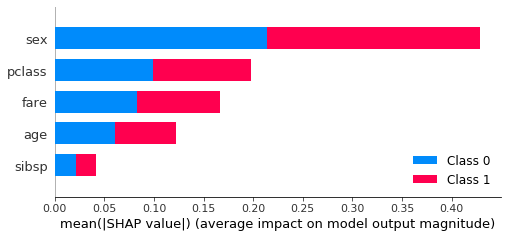

In [20]:
shap.summary_plot(explainer.shap_values(X_test), X_test)

In [21]:
c = 0 # died
shap.force_plot(explainer.expected_value[c], shap_values[c], X_test.iloc[i])

In [22]:
c = 1 # survived
shap.force_plot(explainer.expected_value[c], shap_values[c], X_test.iloc[i])

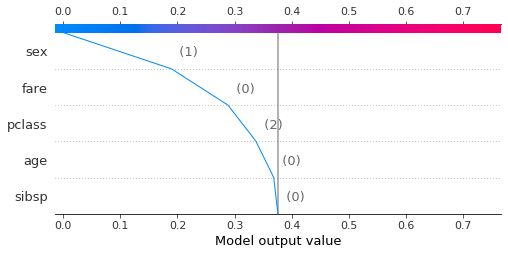

In [23]:
shap.decision_plot(explainer.expected_value[c], shap_values[c], X_test.iloc[i])

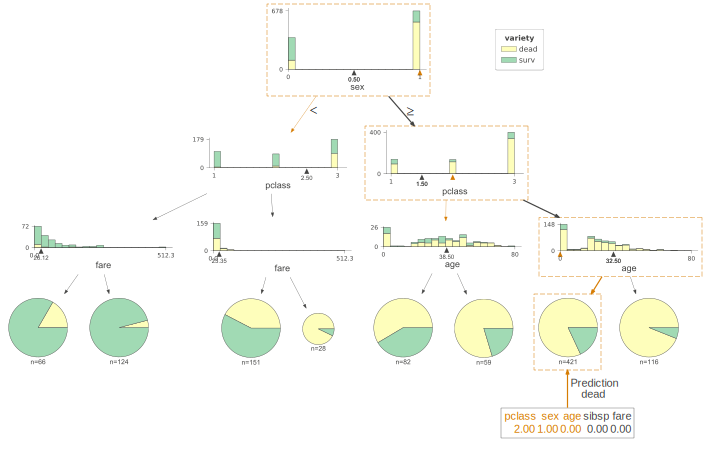

In [24]:
viz = dtreeviz(clf, X_train, y_train, target_name='variety', 
               feature_names=X.columns,
               class_names=["dead", "surv"],
               X=X_test.iloc[i]
)
viz